In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, plot_confusion_matrix
#from itertools import chain
import math

In [2]:
# Function to set appropriate figure size for publication
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim


In [3]:
# Function to slice a nested loop
# Slice list = array[start:stop:step]
def slice_nest(data, start, stop, step):
    #new_arr = np.ones_like(data)   # Create array to contain new sliced sublists
    new_list = []   # List to contain sliced sublist
    
    # Loop through data and slice each sublist - if exists
    for sublist in data:
        new_list.append(sublist[start:stop:step])
        
    # Stack data in column vector numpy array
    #new_arr = np.array(new_list)
    
    # Return sliced array of lists
    return np.array(new_list)

In [4]:
# Data params
textures = 11
trials = 100

# Set bin and sim params
bin_size = 100   # Bin size in ms
sim_length = 5000   # Sim time in ms
bins = math.ceil(sim_length / bin_size)

# Used to iterate through windows
#data_length = list(range(100,5000, 100))   # 100ms intervals by which to use for classifier
data_bin_numbers = [x / bin_size for x in range (100,5000,bin_size)]   # Number of bins each iteration will include

width = 516 # Width of document in publication

In [5]:
# Import clipped dataset and labels from pickle
PATH = "/home/farscope2/Documents/PhD/Spiking Nets Project/SpikingNetsTexture/datasets/TacTip_NM/300ms clipped/" #300ms clipped
DATA_NAME = str(sim_length) + "ms - " + str(bin_size) + "ms bin size dataset.pickle"
LABEL_NAME = str(textures) + " textures - " + str(trials) + " trials labels.pickle"
SAVE_PATH = '/home/farscope2/Documents/PhD/Spiking Nets Project/SpikingNetsTexture/graphs/window_size/'

# Import dataset first
FILENAME = PATH + DATA_NAME

# Create array of intensities for heatmap
with(open(FILENAME, "rb")) as openfile:
    try:
        dataset = pickle.load(openfile)
    except EOFError:
        print(EOFError)
        
# Now import label array
FILENAME = PATH + LABEL_NAME

# Create array of intensities for heatmap
with(open(FILENAME, "rb")) as openfile:
    try:
        labels = pickle.load(openfile)
    except EOFError:
        print(EOFError)

In [6]:
# WARNING: Dataset created from previous script contains a NULL row 0
#          This row has currently been deleted and saved over the initial dataset
#          Note for next time is to fix this bug
#print(dataset[0])
#dataset = np.delete(dataset, 0, 0)
#print(len(dataset))
if len(dataset) == 1101:
    dataset = np.delete(dataset, 0, 0)

In [7]:
# Assess naive bayes over a range of window sizes
# Lists to contain accuracy data
train_accuracies = []
#     train_recall = []
#     train_precision = []

val_accuracies = []
#     val_recall = []
#     val_precision = []
    
# List to track fold accuracies
fold_train_acc = []
fold_val_acc = []
    
# Total confusion arrays
#    Y_true = []
#   Y_Pred = []

# Create kfold validation model
folds = 10
kf = KFold(n_splits=folds, random_state=63, shuffle=True)


# Create KNN classifier
# 2 Neighbours most accurate for this data from prior testing
knn = KNeighborsClassifier(2)

# Loop through window sizes
for num in data_bin_numbers:
    
    # Take first 'num' data points as the data window for this loop
    num_dataset = slice_nest(dataset, 0, int(num), 1)
    
    # Split data into testing and training
    # Ration currently 80-20
    x_train, x_test, y_train, y_test = train_test_split(num_dataset, labels, test_size=0.2)
    

    # Convert training data to np arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # Loop through each of the folds within the kfold
    for train_index, val_index in kf.split(x_train):
        # Create folded data
        Xtrain, Xval = x_train[train_index], x_train[val_index]
        ytrain, yval = y_train[train_index], y_train[val_index]

        # Fit the model to the new folded training data
        knn.fit(Xtrain, ytrain)

        # Precit value using KNN
        #y_pred = knn.predict(x_test)
        pred_train = knn.predict(Xtrain)
        pred_val = knn.predict(Xval)

        # Append values to seperate array for confusion matrix
#         Y_true.append(yval)
#         Y_Pred.append(pred_val)

        #Calculate the accuracy of the predictions on the training set 
        #and save in the variable train_accuracies
        fold_train_acc.append(accuracy_score(ytrain, pred_train))
#         train_recall.append(recall_score(ytrain, pred_train, average='micro'))
#         train_precision.append(precision_score(ytrain, pred_train, average='micro'))

        #Do the same for the predictions on the validation set
        fold_val_acc.append(accuracy_score(yval, pred_val))
#         val_recall.append(recall_score(yval, pred_val, average='micro'))
#         val_precision.append(precision_score(yval, pred_val, average='micro'))
    
    # Append the average accuracy for this window size
    train_accuracies.append(np.mean(fold_train_acc))
    val_accuracies.append(np.mean(fold_val_acc))
    
    # Empty fold tracking lists
    fold_train_acc = []
    fold_val_acc = []
    
    # Debug print statement
    print(str(num * bin_size) + "ms window complete")

100.0ms window complete
200.0ms window complete
300.0ms window complete
400.0ms window complete
500.0ms window complete
600.0ms window complete
700.0ms window complete
800.0ms window complete
900.0ms window complete
1000.0ms window complete
1100.0ms window complete
1200.0ms window complete
1300.0ms window complete
1400.0ms window complete
1500.0ms window complete
1600.0ms window complete
1700.0ms window complete
1800.0ms window complete
1900.0ms window complete
2000.0ms window complete
2100.0ms window complete
2200.0ms window complete
2300.0ms window complete
2400.0ms window complete
2500.0ms window complete
2600.0ms window complete
2700.0ms window complete
2800.0ms window complete
2900.0ms window complete
3000.0ms window complete
3100.0ms window complete
3200.0ms window complete
3300.0ms window complete
3400.0ms window complete
3500.0ms window complete
3600.0ms window complete
3700.0ms window complete
3800.0ms window complete
3900.0ms window complete
4000.0ms window complete
4100.0ms 

In [8]:
#Calculate the mean for training and validation accuracies
train_accuracy_mean = np.mean(train_accuracies)
val_accuracy_mean = np.mean(val_accuracies)
artificial_data = np.array(val_accuracies) * 100

# train_recall_mean = np.mean(train_recall)
# val_recall_mean = np.mean(val_recall)

# train_precision_mean = np.mean(train_precision)
# val_precision_mean = np.mean(val_precision)

# Classify Natural Textures

In [9]:
# Import clipped dataset and labels from pickle
PATH = "/home/farscope2/Documents/PhD/Spiking Nets Project/SpikingNetsTexture/datasets/TacTip_NM/natural_classifier/" #300ms clipped
DATA_NAME = str(sim_length) + "ms - " + str(bin_size) + "ms bin size dataset.pickle"
LABEL_NAME = str(textures) + " textures - " + str(trials) + " trials labels.pickle"
SAVE_PATH = '/home/farscope2/Documents/PhD/Spiking Nets Project/SpikingNetsTexture/graphs/window_size/'

# Import dataset first
FILENAME = PATH + DATA_NAME

# Create array of intensities for heatmap
with(open(FILENAME, "rb")) as openfile:
    try:
        dataset = pickle.load(openfile)
    except EOFError:
        print(EOFError)
        
# Now import label array
FILENAME = PATH + LABEL_NAME

# Create array of intensities for heatmap
with(open(FILENAME, "rb")) as openfile:
    try:
        labels = pickle.load(openfile)
    except EOFError:
        print(EOFError)

In [10]:
# WARNING: Dataset created from previous script contains a NULL row 0
#          This row has currently been deleted and saved over the initial dataset
#          Note for next time is to fix this bug
#print(dataset[0])
#dataset = np.delete(dataset, 0, 0)
#print(len(dataset))
if len(dataset) == 1101:
    dataset = np.delete(dataset, 0, 0)

In [11]:
# Assess naive bayes over a range of window sizes
# Lists to contain accuracy data
train_accuracies = []
#     train_recall = []
#     train_precision = []

val_accuracies = []
#     val_recall = []
#     val_precision = []
    
# List to track fold accuracies
fold_train_acc = []
fold_val_acc = []
    
# Total confusion arrays
#    Y_true = []
#   Y_Pred = []

# Create kfold validation model
folds = 10
kf = KFold(n_splits=folds, random_state=63, shuffle=True)


# Create KNN classifier
# 2 Neighbours most accurate for this data from prior testing
knn = KNeighborsClassifier(2)

# Loop through window sizes
for num in data_bin_numbers:
    
    # Take first 'num' data points as the data window for this loop
    num_dataset = slice_nest(dataset, 0, int(num), 1)
    
    # Split data into testing and training
    # Ration currently 80-20
    x_train, x_test, y_train, y_test = train_test_split(num_dataset, labels, test_size=0.2)
    

    # Convert training data to np arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # Loop through each of the folds within the kfold
    for train_index, val_index in kf.split(x_train):
        # Create folded data
        Xtrain, Xval = x_train[train_index], x_train[val_index]
        ytrain, yval = y_train[train_index], y_train[val_index]

        # Fit the model to the new folded training data
        knn.fit(Xtrain, ytrain)

        # Precit value using KNN
        #y_pred = knn.predict(x_test)
        pred_train = knn.predict(Xtrain)
        pred_val = knn.predict(Xval)

        # Append values to seperate array for confusion matrix
#         Y_true.append(yval)
#         Y_Pred.append(pred_val)

        #Calculate the accuracy of the predictions on the training set 
        #and save in the variable train_accuracies
        fold_train_acc.append(accuracy_score(ytrain, pred_train))
#         train_recall.append(recall_score(ytrain, pred_train, average='micro'))
#         train_precision.append(precision_score(ytrain, pred_train, average='micro'))

        #Do the same for the predictions on the validation set
        fold_val_acc.append(accuracy_score(yval, pred_val))
#         val_recall.append(recall_score(yval, pred_val, average='micro'))
#         val_precision.append(precision_score(yval, pred_val, average='micro'))
    
    # Append the average accuracy for this window size
    train_accuracies.append(np.mean(fold_train_acc))
    val_accuracies.append(np.mean(fold_val_acc))
    
    # Empty fold tracking lists
    fold_train_acc = []
    fold_val_acc = []
    
    # Debug print statement
    print(str(num * bin_size) + "ms window complete")

100.0ms window complete
200.0ms window complete
300.0ms window complete
400.0ms window complete
500.0ms window complete
600.0ms window complete
700.0ms window complete
800.0ms window complete
900.0ms window complete
1000.0ms window complete
1100.0ms window complete
1200.0ms window complete
1300.0ms window complete
1400.0ms window complete
1500.0ms window complete
1600.0ms window complete
1700.0ms window complete
1800.0ms window complete
1900.0ms window complete
2000.0ms window complete
2100.0ms window complete
2200.0ms window complete
2300.0ms window complete
2400.0ms window complete
2500.0ms window complete
2600.0ms window complete
2700.0ms window complete
2800.0ms window complete
2900.0ms window complete
3000.0ms window complete
3100.0ms window complete
3200.0ms window complete
3300.0ms window complete
3400.0ms window complete
3500.0ms window complete
3600.0ms window complete
3700.0ms window complete
3800.0ms window complete
3900.0ms window complete
4000.0ms window complete
4100.0ms 

In [12]:
#Calculate the mean for training and validation accuracies
train_accuracy_mean = np.mean(train_accuracies)
val_accuracy_mean = np.mean(val_accuracies)

natural_data = np.array(val_accuracies) * 100

In [13]:
print(np.max(natural_data) * 0.9)
print(natural_data)

61.670454545454554
[12.38636364 43.29545455 52.61363636 54.09090909 62.38636364 61.70454545
 65.56818182 66.81818182 63.52272727 64.65909091 63.63636364 64.43181818
 64.31818182 64.77272727 64.09090909 64.09090909 64.31818182 64.20454545
 63.29545455 65.90909091 63.75       64.20454545 65.34090909 65.34090909
 66.70454545 65.45454545 64.65909091 68.52272727 65.68181818 63.63636364
 67.5        66.25       64.65909091 67.84090909 65.34090909 66.02272727
 67.38636364 65.45454545 65.45454545 68.40909091 66.02272727 66.13636364
 66.02272727 65.56818182 65.11363636 67.61363636 67.27272727 67.72727273
 66.02272727]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


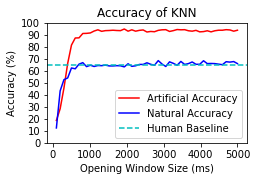

In [14]:
# Print mean values for accuracies
#print(train_accuracy_mean)
# print(val_accuracy_mean)
# print(np.max(val_accuracies))

# Plot this data
x = np.linspace(data_bin_numbers[0] * bin_size, sim_length, len(data_bin_numbers))
xtick = np.arange(0, sim_length + 10, bin_size * 10)
ytick = np.arange(0,110,10)

#print(ytick)

fig, ax = plt.subplots(figsize=set_size(width, fraction=0.5))

ax.plot(x, artificial_data, color='r',label='Artificial Accuracy')
ax.plot(x, natural_data, color='b',label='Natural Accuracy')
plt.axhline(y = 65, color = 'c', linestyle = '--', label='Human Baseline')  # Line to indicate the human baseline
plt.xlabel("Opening Window Size (ms)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy of KNN")
ax.legend()
plt.xticks(xtick)
plt.yticks(ytick)
#plt.yticks(np.arange(0.1, 1.1, step=0.1))
plt.savefig("/home/farscope2/Documents/PhD/Spiking Nets Project/SpikingNetsTexture/graphs/PAPER_FINAL/" +
                    DATA_NAME + " KNN accuracy_baseline.eps",bbox_inches="tight")
plt.show()

In [15]:
# # Print mean values for recall
# print(train_recall_mean)
# print(val_recall_mean)

# # Plot this data
# fig, ax = plt.subplots(figsize=(12,8))

# ax.plot(x, train_recall, color='r',label='Training Recall')
# ax.plot(x, val_recall, color='b',label='Validation Recall')
# plt.xlabel("Fold No.")
# plt.ylabel("Recall")
# plt.title("Recall of Naive Bais for " + DATA_NAME)
# plt.savefig("/home/farscope2/Documents/PhD/Spiking Nets Project/SpikingNetsTexture/graphs/bayes_results/" +
#                     DATA_NAME + " recall.png")
# ax.legend()
# plt.show()

In [16]:
# # Print mean values for precision
# print(train_precision_mean)
# print(val_precision_mean)

# # Plot this data
# fig, ax = plt.subplots(figsize=(12,8))

# ax.plot(x, train_precision, color='r',label='Training Precision')
# ax.plot(x, val_precision, color='b',label='Validation Precision')
# plt.xlabel("Fold No.")
# plt.ylabel("Precision")
# plt.title("Precision of Naive Bais for " + DATA_NAME)
# plt.savefig("/home/farscope2/Documents/PhD/Spiking Nets Project/SpikingNetsTexture/graphs/bayes_results/" +
#                     DATA_NAME + " precision.png")
# ax.legend()
# plt.show()

In [17]:
# Y_true = [item for sublist in Y_true for item in sublist]
# #print(Y_true)
# Y_Pred = [item for sublist in Y_Pred for item in sublist]

In [18]:
#cnf_matrix = confusion_matrix(Y_true, Y_Pred)

In [19]:
# plt.figure(figsize=(6, 6))
# plt.xticks(range(11))
# plt.yticks(range(11))
# plt.imshow(cnf_matrix)
# plt.title('Confusion matrix')
# plt.savefig(SAVE_PATH + DATA_NAME + " BAYES confusion.png")
# plt.show()
# cnf_matrix

In [20]:
# norm = np.linalg.norm(cnf_matrix)
# normal_cnf = cnf_matrix/norm

In [21]:
# plt.figure(figsize=(6, 6))
# plt.xticks(range(11))
# plt.yticks(range(11))
# plt.imshow(normal_cnf)
# plt.title('Normalised Confusion matrix')
# plt.savefig(SAVE_PATH + DATA_NAME + " BAYES normalised confusion.png")
# plt.show()
# normal_cnf